<a href="https://colab.research.google.com/github/DerekSHAOZH/FUB-22Win-Phylogeny-Inference-and-Application/blob/main/Phylogenetics_final_project_DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Configuration

##I. Importing required packages

In [ ]:
from re import search, compile
import math
import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import copy
import os

from google.colab import drive
drive.mount('/content/drive')
import re

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##II. Importing the sequence dataset

In [ ]:
!pwd
# fasta_file_path = "/content/influenza_1019.fasta"
fasta_file_path = "/content/influenza_98.fasta"

/content


##III. Importing the Tree Class for phylogeny inference

In [ ]:
class Vertex:
  def __init__(self,name): 
    self.name = name
    self.in_degree = 0
    self.out_degree = 0
    self.parent = self
    self.children = []
    self.neighbors = []
    self.newick_label = ""
    self.sequence = ""
    self.min_cost_subtree = []
    self.is_leaf = False
    self.is_root = False
    self.subtree = []

class Tree:
  def __init__(self,name):
    self.name = name
    self.vertex_map = {}
    self.pre_order_list = []
    self.post_order_list = []
    self.edge_list_map = {}
    self.root = -1
    self.mut_cost_matrix = np.array([[0, 1, 1, 1], 
                                 [1, 0, 1, 1],
                                 [1, 1, 0, 1],
                                 [1, 1, 1, 0]]) 
    self.total_parsimony_score = 0
    self.DNA_ind_map = {"A":0,"T":1,"G":2,"C":3}
    self.DNA_list = "ATGC"
    self.max_penalty = float(str("inf"))    
    self.first_pos_of_unique_site_pattern_to_pos_list = {}
    self.leaves = []
    self.sequence_length = 0
  def Add_mut_cost_matrix(self,W):
    self.mut_cost_matrix = W  
  def Add_vertex(self,name):    
    v = Vertex(name)
    self.vertex_map[name] = v  
  def Contains_vertex(self,name):
    return (name in self.vertex_map.keys())
  def Get_vertex(self,name):
    if name in self.vertex_map.keys():
      return (self.vertex_map[name])

  def Add_edge(self, end1_name, end2_name, distance):   #FOR PROJECT
    if end1_name not in self.vertex_map.keys():
      self.Add_vertex(end1_name)
    if end2_name not in self.vertex_map.keys():
      self.Add_vertex(end2_name)
    node1 = self.Get_vertex(end1_name)
    node2 = self.Get_vertex(end2_name)   
    node1.neighbors.append(node2)
    node2.neighbors.append(node1)
    self.edge_list_map[(node1,node2)] = distance

  def Add_directed_edge(self, parent_name, child_name, distance):   
    if parent_name not in self.vertex_map.keys():
      self.Add_vertex(parent_name)
    if child_name not in self.vertex_map.keys():
      self.Add_vertex(child_name)
    p = self.Get_vertex(parent_name)
    c = self.Get_vertex(child_name)    
    p.out_degree += 1
    c.in_degree += 1
    c.parent = p
    p.children.append(c)
    self.edge_list_map[(p,c)] = distance
  def Get_edge_length(self, parent, child):
    return (self.edge_list_map[(parent, child)])
  def Set_root(self):
    for vertex in self.vertex_map.values():
      if vertex.in_degree == 0:
        self.root = vertex
        self.root.is_root = True
      else:
        vertex.is_root = False
  def Get_root(self):
    if self.root == -1:
      self.Set_root()
    return (self.root)

  def Set_MST_leaf_flags(self):   #FOR PROJECT
    for v in self.vertex_map.values():
      if len(v.neighbors) == 1:
        v.is_leaf = True
      else:
        v.is_leaf = False
        
  def Set_leaf_flags(self):
    for v in self.vertex_map.values():
      if v.out_degree == 0:
        v.is_leaf = True
      else:
        v.is_leaf = False
  def Set_leaves(self):
    self.leaves = []
    for v in self.vertex_map.values():      
      if v.is_leaf:
        self.leaves.append(v)    
  def Set_pre_order_and_post_order(self):
    self.Set_root()
    self.Set_leaf_flags()
    self.Set_leaves()
    self.pre_order_list = [self.root]
    self.post_order_list = [self.root]
    vertices_to_visit = [self.root]
    while len(vertices_to_visit) > 0:
      v = vertices_to_visit.pop()
      vertices_to_visit += v.children      
      self.post_order_list = v.children + self.post_order_list
      self.pre_order_list = self.pre_order_list + v.children
  def Compute_newick_format(self):
    if len(self.post_order_list) != len(self.vertex_map):
      self.Set_pre_order_and_post_order()
    for v in self.post_order_list:
      if v.out_degree == 0:
        v.newick_label = v.name
      else:        
        c_l = v.children[0]
        c_r = v.children[1]        
        len_l = self.Get_edge_length(v,c_l)
        len_r = self.Get_edge_length(v,c_r)
        v.newick_label = f'({c_l.newick_label}:{len_l},{c_r.newick_label}:{len_r})'
    self.root.newick_label += ";"
    return(self.root.newick_label)    
  def Read_newick_string(self, newick_string):    
    rx = r'\([^()]+\)'
    hidden_vertex_ind = 1
    while "," in newick_string:                  
      # search for the parenthesis
      m = re.search(rx,newick_string)
      # returns a tuple containing all the subgroups of the match "()"
      string_match = m.group()            
      # remove ( and )
      siblings_string = string_match[1:-1]      
      c_left_name_and_length, c_right_name_and_length = siblings_string.split(",")
      c_left_name, c_left_length = c_left_name_and_length.split(":")
      c_right_name, c_right_length = c_right_name_and_length.split(":")
      if not self.Contains_vertex(c_left_name):
          self.Add_vertex(c_left_name)
      if not self.Contains_vertex(c_right_name):
          self.Add_vertex(c_right_name)
      hidden_vertex_name = "h" + str(hidden_vertex_ind)
      self.Add_vertex(hidden_vertex_name)            
      self.Add_directed_edge(hidden_vertex_name, c_left_name, float(c_left_length))
      self.Add_directed_edge(hidden_vertex_name, c_right_name, float(c_right_length))
      newick_string = newick_string.replace(string_match,hidden_vertex_name)
      hidden_vertex_ind += 1 
  def Read_newick_string_without_branch_lengths(self,newick_string):
    rx = r'\([^()]+\)'
    hidden_vertex_ind = 1
    while "," in newick_string:                  
      # search for the parenthesis
      m = re.search(rx,newick_string)
      # returns a tuple containing all the subgroups of the match "()"
      string_match = m.group()            
      # remove ( and )
      siblings_string = string_match[1:-1]      
      c_left_name, c_right_name = siblings_string.split(",")
      # c_left_name, c_left_length = c_left_name_and_length.split(":")
      # c_right_name, c_right_length = c_right_name_and_length.split(":")
      if not self.Contains_vertex(c_left_name):
          self.Add_vertex(c_left_name)
      if not self.Contains_vertex(c_right_name):
          self.Add_vertex(c_right_name)
      hidden_vertex_name = "h" + str(hidden_vertex_ind)
      self.Add_vertex(hidden_vertex_name)            
      self.Add_directed_edge(hidden_vertex_name, c_left_name, 0.001)
      self.Add_directed_edge(hidden_vertex_name, c_right_name, 0.001)      
      newick_string = newick_string.replace(string_match,hidden_vertex_name)
      hidden_vertex_ind += 1 
  def Read_fasta_file(self,fasta_file_name):
    fastaFile = open(fasta_file_name,'r')
    seq = ''
    name = ''
    sequenceAlignment={}
    for line in fastaFile:
        if line.startswith('>'):
            if seq != '':
                seq = seq.upper()
                if not self.Contains_vertex(name):
                  self.Add_vertex(name)
                v = self.Get_vertex(name)
                v.sequence = seq       
                seq = ''
            name = line.strip().split('>')[1]
        else:
            seq += line.strip()
    if not self.Contains_vertex(name):
      self.Add_vertex(name)
    v = self.Get_vertex(name)
    v.sequence = seq    
    self.sequence_length = len(seq)
    # sequenceAlignment[name] = seq
    fastaFile.close()
  def Set_null_sequences_in_ancestors(self):
    for v in self.vertex_map.values():
      if not v.is_leaf:
        v.sequence = "N"*self.sequence_length
  def Get_site_pattern(self,site):
    site_pattern = "".join([l.sequence[site] for l in self.leaves])
    return(site_pattern)
  def Store_pos_list_for_unique_site_patterns(self):
    self.Set_pre_order_and_post_order()
    self.first_pos_of_unique_site_pattern_to_pos_list = {}
    unique_site_pattern_to_first_pos = {}
    for site in range(self.sequence_length):
      site_pattern = "".join([l.sequence[site] for l in self.leaves])
      # print(f"site pattern for pos{site} is {site_pattern}")
      if site_pattern in unique_site_pattern_to_first_pos.keys():                
        first_pos = unique_site_pattern_to_first_pos[site_pattern] 
        self.first_pos_of_unique_site_pattern_to_pos_list[first_pos].append(site)
      else:
        unique_site_pattern_to_first_pos[site_pattern] = site
        self.first_pos_of_unique_site_pattern_to_pos_list[site] = [site]    
  def Is_informative(self,site_pattern):
    counts = Counter(site_pattern)
    return(sum([count > 1 for count in counts.values()])>1)
  def Get_total_number_of_informative_site_patterns(self):
    total_number_of_informative_sites = 0
    total_number_of_informative_site_patterns = 0
    for site in self.first_pos_of_unique_site_pattern_to_pos_list.keys():     
      site_pattern = "".join([l.sequence[site] for l in self.leaves])  
      if (self.Is_informative(site_pattern)):
        pattern_weight = len(self.first_pos_of_unique_site_pattern_to_pos_list[site])        
        total_number_of_informative_sites += pattern_weight
        total_number_of_informative_site_patterns += 1
    print(f"total number of informative sites is {total_number_of_informative_sites}")
    print(f"total number of unique informative_site_patterns is {total_number_of_informative_site_patterns}")
  def Run_Sankoff(self,site):     
    # for site in range(self.self.sequence_length):
    # Phase 1 compute minimum mutation cost for subtrees
    pattern_weight = len(self.first_pos_of_unique_site_pattern_to_pos_list[site])
    pos_list = self.first_pos_of_unique_site_pattern_to_pos_list[site]
    for parent in self.post_order_list:
      if parent.is_leaf:
        parent.min_cost_subtree = [self.max_penalty] * 4
        dna_p_ind = self.DNA_ind_map[parent.sequence[site]]
        parent.min_cost_subtree[dna_p_ind] = 0        
      else:
        parent.min_cost_subtree = [0] * 4
        for dna_p_ind in range(4):
          for child in parent.children:                        
            min_cost_from_child_subtree = self.max_penalty
            for dna_c_ind in range(4):
              min_cost_from_child_subtree = min(min_cost_from_child_subtree, self.mut_cost_matrix[dna_p_ind][dna_c_ind] + child.min_cost_subtree[dna_c_ind])          
            parent.min_cost_subtree[dna_p_ind] += min_cost_from_child_subtree            
    # Phase 2 compute ancestral sequences
    min_cost_ind = self.root.min_cost_subtree.index(min(self.root.min_cost_subtree))
    self.total_parsimony_score += self.root.min_cost_subtree[min_cost_ind] * pattern_weight    
    dna_root = self.DNA_list[min_cost_ind]
    for pos in self.first_pos_of_unique_site_pattern_to_pos_list[site]:      
      self.root.sequence = self.root.sequence[:pos] + dna_root + self.root.sequence[(pos+1):]
    for child in self.pre_order_list[1:]:
      if not child.is_leaf:
        parent = child.parent
        char_parent = parent.sequence[site]
        dna_p_ind = self.DNA_ind_map[char_parent]
        assert(char_parent != "N")
        min_cost_ind = 0
        min_cost = self.max_penalty
        for dna_c_ind in range(4):
          if self.mut_cost_matrix[dna_p_ind][dna_c_ind] + child.min_cost_subtree[dna_c_ind] < min_cost:
            min_cost = self.mut_cost_matrix[dna_p_ind][dna_c_ind] + child.min_cost_subtree[dna_c_ind]
            min_cost_ind = dna_c_ind
        dna_child = self.DNA_list[min_cost_ind]
        for pos in self.first_pos_of_unique_site_pattern_to_pos_list[site]:
          child.sequence = child.sequence[:pos] + dna_child + child.sequence[(pos+1):]    
  def Run_Sankoff_for_all_sites(self):
    self.Set_pre_order_and_post_order()
    self.Set_null_sequences_in_ancestors()
    for site in self.first_pos_of_unique_site_pattern_to_pos_list.keys():
      site_pattern = "".join([l.sequence[site] for l in self.leaves])
      self.Run_Sankoff(site)
  def Suppress_the_root(self):
    root = self.Get_root()
    self.Set_neighbors(root)
    del self.vertex_map[root.name]
    for v in self.vertex_map.values():
      v.parent = -1
      v.children = []
  def Set_neighbors(self, vertex):
    vertex.neighbors.extend(vertex.children)
    for c in vertex.children:
      if vertex.is_root:
        # c.neighbors.extend(list(set(vertex.children) - set(c)))
        c.neighbors.extend([item for item in vertex.children if item.name != c.name])
        self.Set_neighbors(c)
      else:
        c.neighbors.append(vertex)
        self.Set_neighbors(c)

  def Root_tree_along_branch(self, node1_name, node2_name):
    self.Add_vertex("root")
    self.Set_root()
    self.root.out_degree = 2
    vertices_to_visit = [self.root]
    while len(vertices_to_visit) > 0:
      v = vertices_to_visit.pop()
      if v.is_root:
        v.children = [self.Get_vertex(node1_name), self.Get_vertex(node2_name)]
        for child in v.children:
            child.parent = v

        vertices_to_visit += v.children
      elif v.name == node1_name:
        if v.is_leaf:
          v.neighbors = []
          continue
        else:
          v.children = v.neighbors
          v.children.remove(self.Get_vertex(node2_name))
          for child in v.children:
            child.parent = v
          v.neighbors = []

          vertices_to_visit += v.children
      elif v.name == node2_name:
        if v.is_leaf:
          v.neighbors = []
          continue
        else:
          v.children = v.neighbors
          v.children.remove(self.Get_vertex(node1_name))
          for child in v.children:
            child.parent = v
          v.neighbors = []

          vertices_to_visit += v.children
      else:
        if v.is_leaf:
          v.neighbors = []
          continue
        else:
          v.children = v.neighbors
          v.children.remove(v.parent)
          for child in v.children:
            child.parent = v
          v.neighbors = []

          vertices_to_visit += v.children
    self.total_parsimony_score = 0
    # for v in T.vertex_map.values():
    #   v.neighbors = []
    

  def NNI(self, node1_name, node2_name):
    T1 = copy.deepcopy(self)

    node1_subtrees = T1.Get_vertex(node1_name).neighbors
    print([v.name for v in node1_subtrees])
    node1_subtrees.remove(T1.Get_vertex(node2_name))
    subtree_1 = node1_subtrees[0]
    subtree_2 = node1_subtrees[1]

    node2_subtrees = T1.Get_vertex(node2_name).neighbors
    node2_subtrees.remove(T1.Get_vertex(node1_name))
    subtree_3 = node2_subtrees[0]
    subtree_4 = node2_subtrees[1]
   
    T1.Get_vertex(node1_name).neighbors = [subtree_1, subtree_3, T1.Get_vertex(node2_name)]
    T1.Get_vertex(node2_name).neighbors = [subtree_4, subtree_2, T1.Get_vertex(node1_name)]
    subtree_2.neighbors.remove(T1.Get_vertex(node1_name))
    subtree_2.neighbors.append(T1.Get_vertex(node2_name))
    subtree_3.neighbors.remove(T1.Get_vertex(node2_name))
    subtree_3.neighbors.append(T1.Get_vertex(node1_name))

    T2 = copy.deepcopy(self)

    node1_subtrees = T2.Get_vertex(node1_name).neighbors
    node1_subtrees.remove(T2.Get_vertex(node2_name))
    subtree_1 = node1_subtrees[0]
    subtree_2 = node1_subtrees[1]

    node2_subtrees = T2.Get_vertex(node2_name).neighbors
    node2_subtrees.remove(T2.Get_vertex(node1_name))
    subtree_3 = node2_subtrees[0]
    subtree_4 = node2_subtrees[1]

    T2.Get_vertex(node1_name).neighbors = [subtree_1, subtree_4, T2.Get_vertex(node2_name)]
    T2.Get_vertex(node2_name).neighbors = [subtree_3, subtree_2, T2.Get_vertex(node1_name)]
    subtree_2.neighbors.remove(T2.Get_vertex(node1_name))
    subtree_2.neighbors.append(T2.Get_vertex(node2_name))
    subtree_4.neighbors.remove(T2.Get_vertex(node2_name))
    subtree_4.neighbors.append(T2.Get_vertex(node1_name))

    return T1, T2

##IV. Defining the mutation cost matrix for maximum parsimony 

In [ ]:
W = np.array([[0, 1, 1, 1], 
              [1, 0, 1, 1],
              [1, 1, 0, 1],
              [1, 1, 1, 0]])

#1. Constructing a minimum-spanning tree 


##I. Computing pairwise Jukes-Cantor distances between sequences

In [ ]:
def jukes_cantor_distance(sequence1, sequence2):
  # print('computing JC distance')
  nucleotide_diff_count = 0 # how many nucleotides they differ
  total_nucleotides_compared = 0.0
  bases = {'A', 'C', 'G', 'T'}
  
  for a, b in zip(sequence1, sequence2):
    if a in bases and b in bases:
      # total_nucleotides_compared += 1
      if a != b: 
        nucleotide_diff_count += 1
      
  nucleotide_diff_percentage = nucleotide_diff_count / len(sequence1)
  # diff_pct_adjusted = min(nucleotide_diff_percentage, 0.74999)
  # jukes_cantor_distance = -0.75 * math.log(1 - min((diff_pct_adjusted*(4.0/3.0)),1.0))
  jukes_cantor_distance = -0.75 * math.log(1 - (nucleotide_diff_percentage*(4.0/3.0)))
  return jukes_cantor_distance

In [ ]:
sequences = {}
jc_distances = {}

fasta_file = open(fasta_file_path,'r')
seq = ''
seq_id = ''
for line in fasta_file:
  if line.startswith('>'):
    seq_id = line.strip().split('>')[1]
    seq = ''
  else:
    seq += line.strip()
  if seq != '' and seq_id != '':
    sequences[seq_id] = seq
print(sequences["EPI_ISL_21292_2007"])


dist_mat = np.zeros((len(sequences), len(sequences)))


for i in range(len(sequences)):
  for j in range(i+1, len(sequences)):
    dist_mat[i][j] = jukes_cantor_distance(sequences[list(sequences.keys())[i]], sequences[list(sequences.keys())[j]])

dist_mat

#     # compute distance with regard to the previously read sequences
# seq_id1_pairwise_dist = {}
# # for seq_id_to_compare in sequences:

# # seq_to_compare = sequences[seq_id_to_compare]
# seq_id1 = 'EPI_ISL_21292_2007'
# seq_id2 = 'EPI_ISL_14257_2001'
# seq1 = sequences[seq_id1]
# seq2 = sequences[seq_id2]

# seq1 = sequences[seq_id1]
# for seq_id1, seq1 in sequences.items():
#   for seq_id2, seq2 in sequences.items():
#     dist = jukes_cantor_distance(seq1, seq2)
#     seq_id1_pairwise_dist[seq_id2] = dist
#   # print(f'{seq_id}\t{seq_id_to_compare}\t{dist}')
#   jc_distances[seq_id1] = seq_id1_pairwise_dist
# # print(jc_distances[seq_id1][seq_id2])

CAAAAACTTCCTGGAAATGACAACAGCACGGCAACGCTGTGCCTTGGGCACCATGCAGTACCAAACGGAACGATAGTGAAAACAATCACGAATGACCAAATTGAAGTTACTAATGCTACTGAGCTGGTTCAGAGTTCCTCAACAGGTGAAATATGCGACAGTCCTCATCAGATCCTTGATGGAGAAAACTGCACACTAATAGATGCTCTATTGGGAGACCCTCAGTGTGATGGCTTCCAAAATAAGAAATGGGACCTTTTTGTTGAACGCAGCAAAGCCTACAGCAACTGTTACCCTTATGATGTGCCGGATTATGCCTCCCTTAGGTCACTAGTTGCCTCATCCGGCACACTGGAGTTTAACAATGAAAGCTTCAATTGGACTGGAGTCACTCAAAACGGAACAAGCTCTTCTTGCATAAGGAGATCTAATAACAGTTTCTTTAGTAGATTGAATTGGTTGACCCACTTAAAATTCAAATACCCAGCATTGAACGTGACTATGCCAAACAATGAAAAATTTGACAAATTGTACATTTGGGGGGTTCACCACCCGGGTACGGACAATGACCAAATCTTCCTGTATGCTCAAGCATCAGGAAGAATCACAGTCTCTACCAAAAGAAGCCAACAAACTGTAATCCCGAATATCGGATCTAGACCCAGAGTAAGGAATATCCCCAGCAGAATAAGCATCTATTGGACAATAGTAAAACCGGGAGACATACTTTTGATTAACAGCACAGGGAATCTAATTGCTCCTAGGGGTTACTTCAAAATACGAAGTGGGAAAAGCTCAATAATGAGATCAGATGCACCCATTGGCAAATGCAATTCTGAATGCATCACTCCAAATGGGAGCATTCCCAATGACAAACCATTCCAAAATGTAAACAGGATCACATACGGGGCCTGTCCCAGATATGTTAAGCAAAACACTCTGAAATTGGCAACAGGGATGCGAAATGTACCAGAGAAACAAACTAGAGGCATATTTGGCG

array([[0.        , 0.01456356, 0.05277558, ..., 0.11401216, 0.12756674,
        0.12075883],
       [0.        , 0.        , 0.05174465, ..., 0.10510997, 0.11850319,
        0.11177668],
       [0.        , 0.        , 0.        , ..., 0.08653656, 0.10400459,
        0.0995993 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.04456757,
        0.040497  ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00773203],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

##II. Creating a fully connected graph with distance matrix

In [ ]:
seq_id = list(sequences.keys())
G = nx.Graph()
G.add_nodes_from(seq_id)
for i in range(len(seq_id)):
  for j in range(i+1, len(seq_id)):
    G.add_edge(seq_id[i], seq_id[j], weight = dist_mat[i][j])

In [ ]:
# G.edges()

##III. Computing the MST in the connected graph

In [ ]:
MST = nx.minimum_spanning_tree(G)
len(list(MST.edges()))

97

In [ ]:
print(MST)

Graph with 98 nodes and 97 edges


##IV. Visualizing the MST

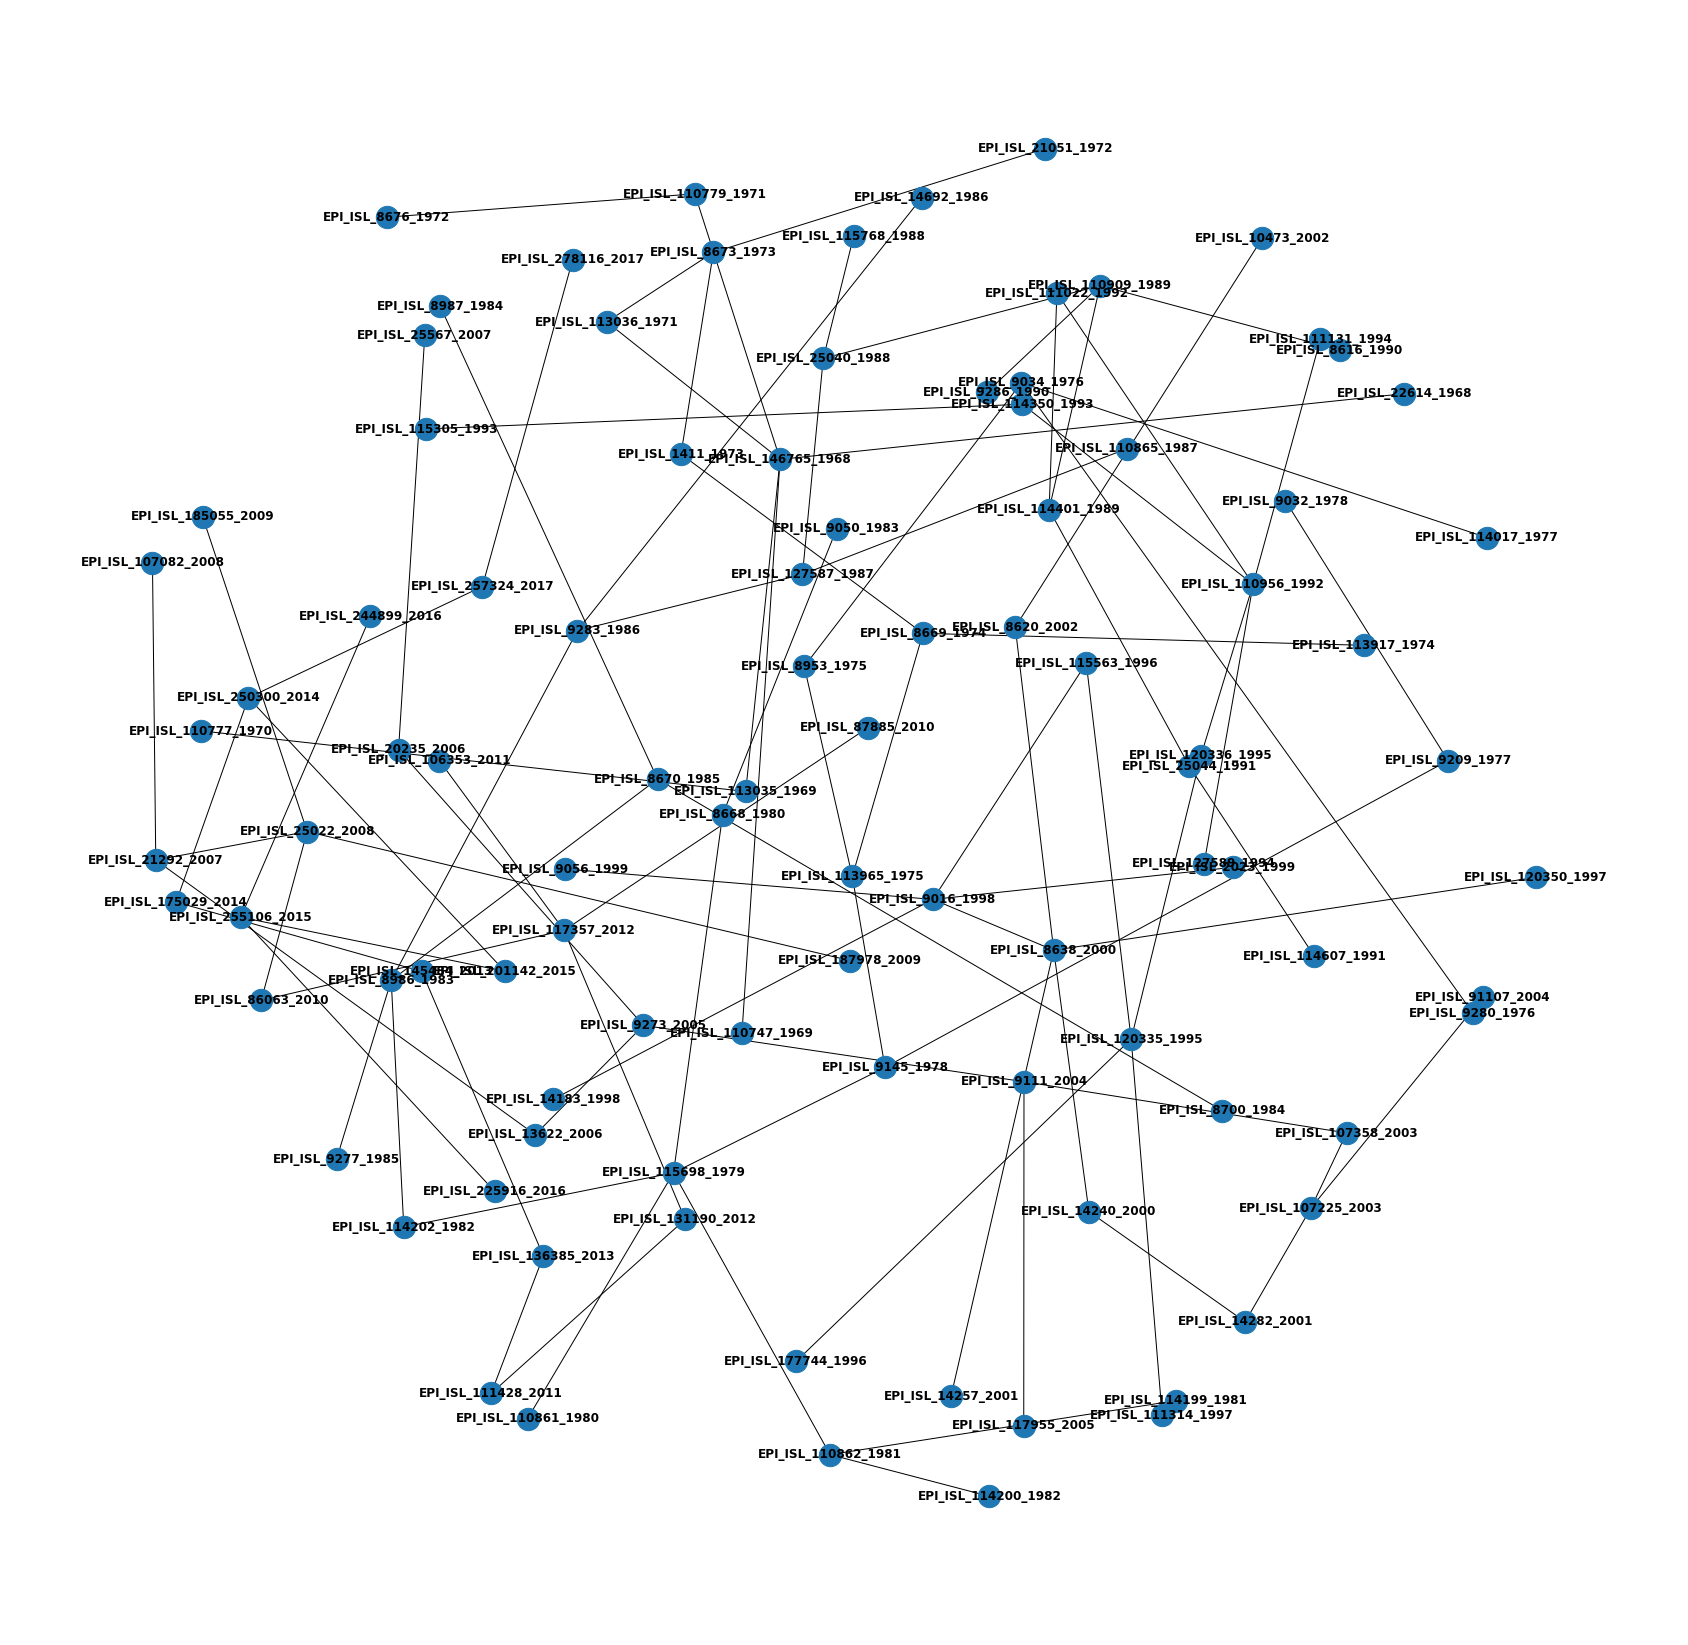

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))
nx.draw(MST, with_labels=True, font_weight='bold', node_size = 500)

#2. Defining a global phylogeny tree

In [ ]:
T_global = Tree("global")
T_global.Read_fasta_file(fasta_file_path)

#! Enclose block 3 & 4 in a while loop !

In [ ]:
#while len(global_edges) < len(global_vertices) - 1:

#3. Constructing MST-induced local subtrees

##I. Converting networkx object to our own Tree class

In [ ]:
M = Tree('MST')
for edge_tuple in MST.edges():
  M.Add_edge(edge_tuple[0], edge_tuple[1], MST.get_edge_data(edge_tuple[0], edge_tuple[1])['weight'])

In [ ]:
list(MST.edges())

[('EPI_ISL_21292_2007', 'EPI_ISL_25022_2008'),
 ('EPI_ISL_21292_2007', 'EPI_ISL_107082_2008'),
 ('EPI_ISL_21292_2007', 'EPI_ISL_13622_2006'),
 ('EPI_ISL_25567_2007', 'EPI_ISL_20235_2006'),
 ('EPI_ISL_14257_2001', 'EPI_ISL_8638_2000'),
 ('EPI_ISL_14282_2001', 'EPI_ISL_14240_2000'),
 ('EPI_ISL_14282_2001', 'EPI_ISL_107225_2003'),
 ('EPI_ISL_2023_1999', 'EPI_ISL_9016_1998'),
 ('EPI_ISL_9056_1999', 'EPI_ISL_9016_1998'),
 ('EPI_ISL_9016_1998', 'EPI_ISL_14183_1998'),
 ('EPI_ISL_9016_1998', 'EPI_ISL_115563_1996'),
 ('EPI_ISL_9016_1998', 'EPI_ISL_8638_2000'),
 ('EPI_ISL_177744_1996', 'EPI_ISL_120335_1995'),
 ('EPI_ISL_115563_1996', 'EPI_ISL_120335_1995'),
 ('EPI_ISL_120350_1997', 'EPI_ISL_8638_2000'),
 ('EPI_ISL_111314_1997', 'EPI_ISL_120335_1995'),
 ('EPI_ISL_111428_2011', 'EPI_ISL_131190_2012'),
 ('EPI_ISL_111428_2011', 'EPI_ISL_136385_2013'),
 ('EPI_ISL_106353_2011', 'EPI_ISL_117357_2012'),
 ('EPI_ISL_10473_2002', 'EPI_ISL_8620_2002'),
 ('EPI_ISL_8620_2002', 'EPI_ISL_8638_2000'),
 ('EPI_ISL

In [ ]:
M.Set_MST_leaf_flags()
M.Set_leaves()

##II. Selecting $V_s$ from the MST such that it induces a subtree
- The number of nodes for $V_s$ can be configured as desired, e.g. 10 nodes



In [ ]:
def find_subtree(T, threshold): # e.g. threshold = 10
  # initialize vertices_to_visit to all of the leaves
  vertices_to_visit = T.leaves
  while len(vertices_to_visit) > 0:
    v = vertices_to_visit.pop(0)
  
    if v.is_leaf:
        v.subtree.append(v)
        if v.neighbors[0] not in vertices_to_visit:
          vertices_to_visit.extend(v.neighbors)
    else:
    #if v is an internal vertex, 
      #check the number of neighbors with empty subtrees
      num_neighbor_with_empty_subtree = sum([len(n.subtree) == 0 for n in v.neighbors])
      # print(num_neighbor_with_empty_subtree)

      #if only one of its neighbors has an empty(unassigned) subtree, assign the subtree at this node
      if num_neighbor_with_empty_subtree == 1:
        # print(v.name)
        v.subtree.append(v)
        for n in v.neighbors:
          if len(n.subtree) > 0:
            for subtree_vertex in n.subtree:
              if subtree_vertex not in v.subtree:
                v.subtree.append(subtree_vertex)
          elif n not in vertices_to_visit:
            vertices_to_visit.append(n)

      #if the number of neighbors with empty(unassigned) subtrees > 1, 
      #then queue this vertex for re-visiting after updating its neighbors
      else:
        for n in v.neighbors:
          if len(n.subtree) == 0 and n not in vertices_to_visit:
            vertices_to_visit.append(n)
        vertices_to_visit.append(v)
 
    if len(v.subtree) >= threshold: 
      return v.subtree


In [ ]:
for vertex_name in M.vertex_map.keys():
  M.Get_vertex(vertex_name).subtree = []
Vs = find_subtree(M, 10)

In [ ]:
[i.name for i in Vs]

['EPI_ISL_8673_1973',
 'EPI_ISL_113036_1971',
 'EPI_ISL_146765_1968',
 'EPI_ISL_110747_1969',
 'EPI_ISL_113035_1969',
 'EPI_ISL_110777_1970',
 'EPI_ISL_110779_1971',
 'EPI_ISL_8676_1972',
 'EPI_ISL_22614_1968',
 'EPI_ISL_21051_1972']

- Visualizing $V_s$ in MST


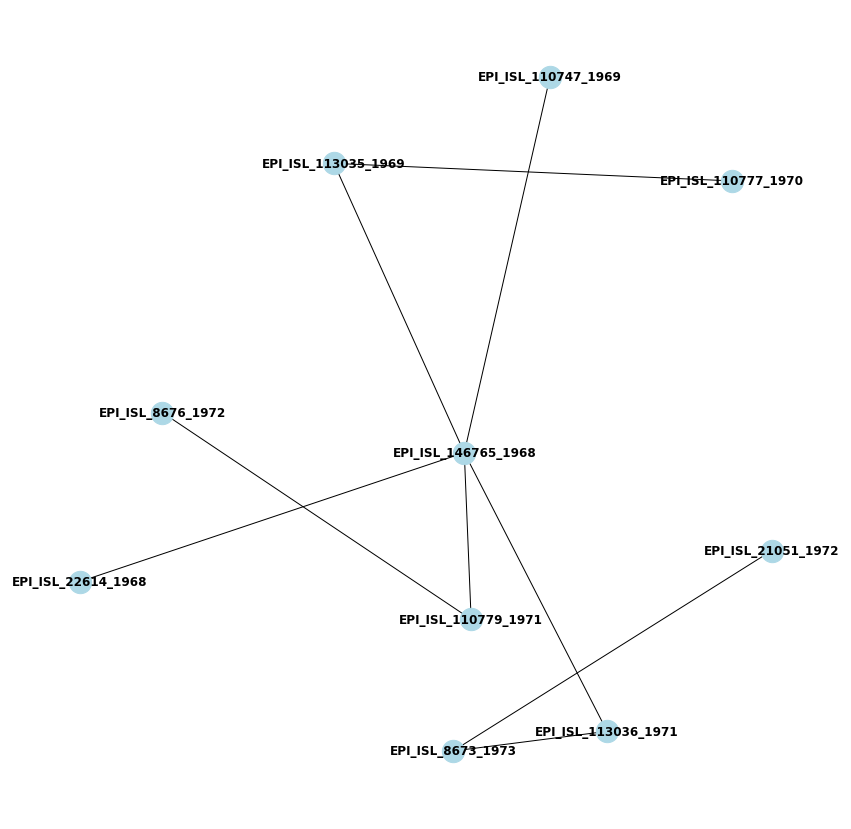

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
H = nx.subgraph(MST, [v.name for v in Vs])
nx.draw(H, with_labels=True, font_weight='bold', node_color='lightblue', node_size=500)

##III. Selecting $V_e$ by performing BFS from the root of the induced subtree from $V_s$
- The number of nodes for $V_e$ should be the same as the number of. nodes chosen for $V_s$
- Can use `networkx` BFS functions such as `descendants_at_distance(G, source, distance)` (see [documentation](https://networkx.org/documentation/stable/reference/algorithms/traversal.html))


In [ ]:
#define the function to find Ve with BFS 
#input: MST tree, Vs, threshold for Ve which is consistent with Vs
#output: Ve consisting of neighboring vertices of Vs
def extra_vertices_with_bfs(MST, Vs, threshold): #function for BFS
  Ve = [] 
  visited = []  #List for visited nodes.
  queue = []     #Initialize a queue

  visited.append(Vs[0])
  queue.append(Vs[0])

  while queue:          # Creating loop to visit each node
    m = queue.pop(0) 
    
    for neighbor in MST.Get_vertex(m.name).neighbors:
      if neighbor not in visited:
        visited.append(neighbor)
        queue.append(neighbor)
        if neighbor not in Ve and neighbor not in Vs: #vertices in Vs should not be in Ve
          Ve.append(neighbor)
      if len(Ve) >= threshold:
        return Ve




In [ ]:
Ve = extra_vertices_with_bfs(M, Vs, 10)

##IV. Creating the initial unrooted tree with the union of $V_s, V_e$

In [ ]:
#define the function to initiate a simplest newick form
#input: the vertex list consisting of Ve and Vs
#output: simplist newick format with all vertices as leaves
#e.g., (A, (B, C));
def newick_for_initial_tree(vertex_list):
  newick = ''
  for i in range(len(vertex_list)):
    if i != len(vertex_list) - 1:
      newick = f'{newick}({vertex_list[i].name},'
    else:
      newick = newick + vertex_list[i].name + (')'*(len(vertex_list)-1)) + ';'
  return newick

In [ ]:
V = Vs + Ve
newick_str = newick_for_initial_tree(V)
newick_str

'(EPI_ISL_8673_1973,(EPI_ISL_113036_1971,(EPI_ISL_146765_1968,(EPI_ISL_110747_1969,(EPI_ISL_113035_1969,(EPI_ISL_110777_1970,(EPI_ISL_110779_1971,(EPI_ISL_8676_1972,(EPI_ISL_22614_1968,(EPI_ISL_21051_1972,(EPI_ISL_1411_1973,(EPI_ISL_8669_1974,(EPI_ISL_113965_1975,(EPI_ISL_113917_1974,(EPI_ISL_8953_1975,(EPI_ISL_9145_1978,(EPI_ISL_9034_1976,(EPI_ISL_9209_1977,(EPI_ISL_115698_1979,EPI_ISL_9280_1976)))))))))))))))))));'

- Visualizing the union of $V_s, V_e$ in MST

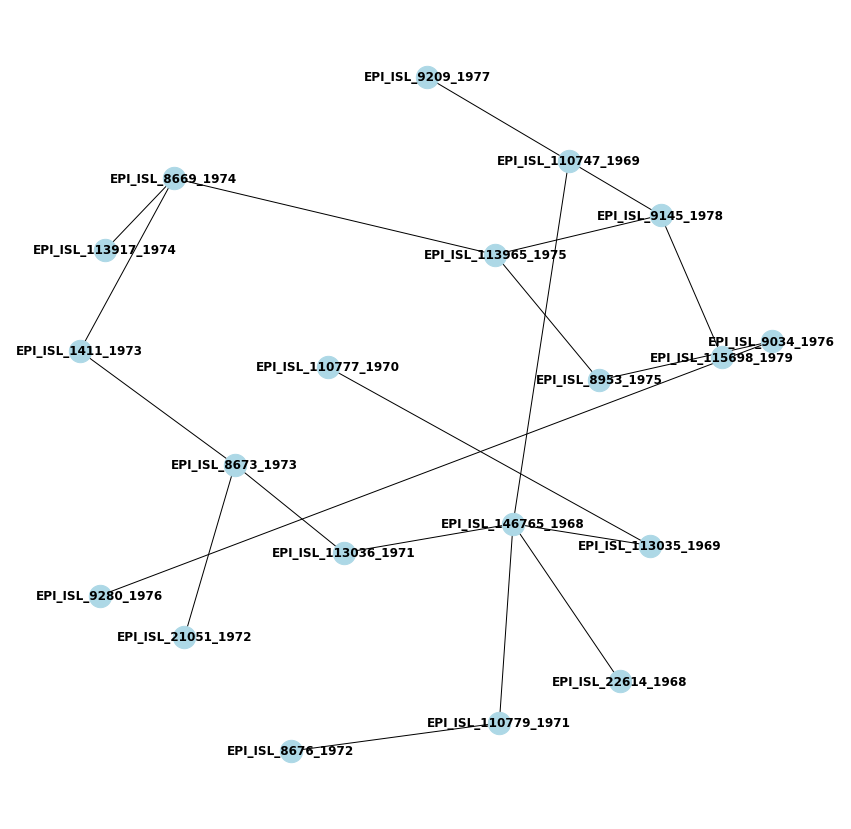

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
H = nx.subgraph(MST, [v.name for v in V])
nx.draw(H, with_labels=True, font_weight='bold', node_color='lightblue', node_size=500)

In [ ]:
T = Tree('local')
T.Read_newick_string_without_branch_lengths(newick_str)
for v in V:
  T.Get_vertex(v.name).sequence = sequences[v.name]
  #print(T.Get_vertex(v.name).sequence)
T.sequence_length = len(sequences[V[0].name])
# for l in T.leaves:
#   print(l.sequence)

# for v in T.vertex_map.values():
#   print(f'vertex {v.name}: out-degree {v.out_degree}, neighbors {[n.name for n in v.neighbors]}, parent {v.parent.name}, children {[c.name for c in v.children]}')

T.Add_mut_cost_matrix(W)
T.Store_pos_list_for_unique_site_patterns()
print(f"Total number of unique site patterns is {len(T.first_pos_of_unique_site_pattern_to_pos_list)}")
T.Get_total_number_of_informative_site_patterns()
T.Run_Sankoff_for_all_sites()
total_parsimony_score = T.total_parsimony_score
print(f"Total parsimony score is {T.total_parsimony_score}")

T.Suppress_the_root()


Total number of unique site patterns is 107
total number of informative sites is 88
total number of unique informative_site_patterns is 59
Total parsimony score is 268


##V. Finding the local tree with maximum parsimony score

In [ ]:
def find_internal_edge(T):
  internal_vertex_names = [v.name for v in T.vertex_map.values() if v.is_leaf == False]
  internal_edge_possibilities = list(itertools.combinations(internal_vertex_names,2))
  internal_edges = [p for p in internal_edge_possibilities if T.Get_vertex(p[0]) in T.Get_vertex(p[1]).neighbors]
  return internal_edges



#input: unrooted tree
def search_tree(tree, root_branch_node1, root_branch_node2, nni_node1, nni_node2):
  # 1. COMPUTE A TREE
  # root the tree at an arbitrary branch
  tree.Root_tree_along_branch(root_branch_node1, root_branch_node2)

  # 2. COMPUTE THE PARSIMONY SCORE (of the rooted tree)
  tree.Run_Sankoff_for_all_sites()
  total_parsimony_score = tree.total_parsimony_score
  print(f"Total parsimony score is {tree.total_parsimony_score}")

  # 3. MODIFY TREE TOPOLOGY
  tree.Suppress_the_root()
  T1, T2 = tree.NNI(nni_node1, nni_node2)

  T1.Root_tree_along_branch(nni_node1, nni_node2)
  T2.Root_tree_along_branch(nni_node1, nni_node2)
  T1.Run_Sankoff_for_all_sites()
  T2.Run_Sankoff_for_all_sites()
  T1_parsimony_score = T1.total_parsimony_score
  T2_parsimony_score = T2.total_parsimony_score
  print(f"T1 parsimony score: {T1_parsimony_score}")
  print(f"T2 parsimony score: {T2_parsimony_score}")

  if T1_parsimony_score < total_parsimony_score and T1_parsimony_score < T2_parsimony_score:
    print("changing to T1")
    T1.Suppress_the_root()
    return T1
  elif T2_parsimony_score < total_parsimony_score and T2_parsimony_score < T1_parsimony_score:
    print("changing to T2")
    T2.Suppress_the_root()
    return T2
  else:
    print("not changing tree topology")
    return tree 

In [ ]:
T_lowest = T
cur_lowest_parsimony_score = float('inf')
continue_search = True

while(continue_search):
  # print("one more while iteration")
  T_new = T_lowest
  continue_search = False
  internal_edges = find_internal_edge(T_lowest)
  

  for b in internal_edges:
    print(f'NNI branch: ({b[0]}, {b[1]})')
    tree = search_tree(T_new, b[0], b[1], b[0], b[1])
    if tree.total_parsimony_score < cur_lowest_parsimony_score:
      # print("Update continue_search to TRUE")
      cur_lowest_parsimony_score = tree.total_parsimony_score
      T_lowest = tree
      continue_search = True

  # print(continue_search)

NNI branch: (h1, h2)
Total parsimony score is 268
['h2', 'EPI_ISL_115698_1979', 'EPI_ISL_9280_1976']
T1 parsimony score: 268
T2 parsimony score: 253
changing to T2
NNI branch: (h2, h3)
Total parsimony score is 268
['h3', 'h1', 'EPI_ISL_9209_1977']
T1 parsimony score: 268
T2 parsimony score: 268
not changing tree topology
NNI branch: (h3, h4)
Total parsimony score is 268
['h4', 'h2', 'EPI_ISL_9034_1976']
T1 parsimony score: 268
T2 parsimony score: 253
changing to T2
NNI branch: (h4, h5)
Total parsimony score is 268
['h5', 'h3', 'EPI_ISL_9145_1978']
T1 parsimony score: 268
T2 parsimony score: 268
not changing tree topology
NNI branch: (h5, h6)
Total parsimony score is 268
['h6', 'h4', 'EPI_ISL_8953_1975']
T1 parsimony score: 272
T2 parsimony score: 271
not changing tree topology
NNI branch: (h6, h7)
Total parsimony score is 268
['h7', 'h5', 'EPI_ISL_113917_1974']
T1 parsimony score: 268
T2 parsimony score: 266
changing to T2
NNI branch: (h7, h8)
Total parsimony score is 268
['h8', 'h6', 

In [ ]:
print(f'Best parsimony score: {cur_lowest_parsimony_score}')
# print(f'\nBest tree: {T_lowest.Compute_newick_format()}')
for v in T_lowest.vertex_map.values():
  print(f'vertex {v.name} has neighbors {[n.name for n in v.neighbors]}')

Best parsimony score: 190
vertex EPI_ISL_115698_1979 has neighbors ['h1']
vertex EPI_ISL_9280_1976 has neighbors ['h3']
vertex h1 has neighbors ['h2', 'h4', 'EPI_ISL_115698_1979']
vertex EPI_ISL_9209_1977 has neighbors ['h4']
vertex h2 has neighbors ['h6', 'h5', 'h1']
vertex EPI_ISL_9034_1976 has neighbors ['h3']
vertex h3 has neighbors ['h5', 'EPI_ISL_9034_1976', 'EPI_ISL_9280_1976']
vertex EPI_ISL_9145_1978 has neighbors ['h4']
vertex h4 has neighbors ['h1', 'EPI_ISL_9145_1978', 'EPI_ISL_9209_1977']
vertex EPI_ISL_8953_1975 has neighbors ['h5']
vertex h5 has neighbors ['h2', 'h3', 'EPI_ISL_8953_1975']
vertex EPI_ISL_113917_1974 has neighbors ['h7']
vertex h6 has neighbors ['h7', 'h2', 'EPI_ISL_113965_1975']
vertex EPI_ISL_113965_1975 has neighbors ['h6']
vertex h7 has neighbors ['h8', 'h6', 'EPI_ISL_113917_1974']
vertex EPI_ISL_8669_1974 has neighbors ['h8']
vertex h8 has neighbors ['h9', 'h7', 'EPI_ISL_8669_1974']
vertex EPI_ISL_1411_1973 has neighbors ['h9']
vertex h9 has neighbors

##VI. Finding the subtree induced by only $V_s$ in the local tree
- Select the vertices that have the same parent, and replace those vertices with the newly created parent vertex


In [ ]:
#define the funtion to find substrees consisting of only Vs nodes
#input: local unrooted phylogeny tree, Vs
#output: dictionary with a tuple of two child nodes from Vs as key and the corresponding hidden vertex as value 
#e.g.,    A
#        / \
#       B   C
# !!!! 
def informative_subtree(tree, Vs):
  forest = {}
  for v_tuple in itertools.combinations(Vs, 2):
    # if v_tuple[0].parent.name == v_tuple[1].parent.name:
    if tree.Get_vertex(v_tuple[0].name).neighbors[0] is tree.Get_vertex(v_tuple[1].name).neighbors[0]:
      forest[v_tuple] = tree.Get_vertex(v_tuple[0].name).neighbors[0]
  
  return forest


In [ ]:
forest = informative_subtree(T_lowest, Vs)

##VII. Updating the global phylogeny tree
- Add newly created parent vertex and selected vertices to the global phylogenetic tree

In [ ]:
for children, parent_new in forest.items():
  T_global.Add_edge(children[0], parent_new, 0.1)
  print(f'Added edge from {children[0].name} to {parent_new.name}, distance = 0.1')

Added edge from EPI_ISL_8673_1973 to h18, distance = 0.1
Added edge from EPI_ISL_113035_1969 to h15, distance = 0.1
Added edge from EPI_ISL_110779_1971 to h13, distance = 0.1


#4. Updating MST
- find different package (other than `networkx` that take as input only the distance matrix and creates the MST (giving us the edge list as output)
- update the distance matrix to remove entries for the selected vertices that are being replaced by the new parent vertices, add entries for the new parent verties
- compute new MST (https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.minimum_spanning_tree.html) 
- repeat process from step 1

##I. Deleting some $V_s$ vertices and Adding the new parent vertices to MST

In [ ]:
def update_sequences(forest, seq_dict):
  sequences_new = seq_dict.copy()
  for children, parent_new in forest.items():
    if children[0].name in sequences.keys():
      del sequences_new[children[0].name]
      print(f'removed {children[0].name} from sequences_new')
    if children[1].name in sequences.keys():
      del sequences_new[children[1].name]
      print(f'removed {children[1].name} from sequences_new')
    sequences_new[parent_new.name] = parent_new.sequence
    print(f'added {parent_new.name} to sequences_new')
  return sequences_new

In [ ]:
for children, parent_new in forest.items():
  print(f'keys: {children[0].name}, {children[1].name}, value: {parent_new.name}')

keys: EPI_ISL_8673_1973, EPI_ISL_113036_1971, value: h18
keys: EPI_ISL_113035_1969, EPI_ISL_110777_1970, value: h15
keys: EPI_ISL_110779_1971, EPI_ISL_8676_1972, value: h13


In [ ]:
sequences_updated = update_sequences(forest, sequences)

removed EPI_ISL_8673_1973 from sequences_new
removed EPI_ISL_113036_1971 from sequences_new
added h18 to sequences_new
removed EPI_ISL_113035_1969 from sequences_new
removed EPI_ISL_110777_1970 from sequences_new
added h15 to sequences_new
removed EPI_ISL_110779_1971 from sequences_new
removed EPI_ISL_8676_1972 from sequences_new
added h13 to sequences_new


In [ ]:
print(f'len(sequences): {len(sequences)} --> len(sequences_updated): {len(sequences_updated)}')

len(sequences): 98 --> len(sequences_updated): 95


##II. Updating the distance matrix with the union of $V_s, V_e$

In [ ]:
def update_distance_matrix(seq_dict):
  dist_mat_new = np.zeros((len(seq_dict), len(seq_dict)))
  
  for i in range(len(seq_dict)):
    for j in range(i+1, len(seq_dict)):
      dist_mat_new[i][j] = jukes_cantor_distance(seq_dict[list(seq_dict.keys())[i]], seq_dict[list(seq_dict.keys())[j]])
  return dist_mat_new

In [ ]:
dist_mat_updated = update_distance_matrix(sequences_updated)

In [ ]:
print(f'dist_mat.shape: {dist_mat.shape} --> dist_mat_updated.shape: {dist_mat_updated.shape}')


dist_mat.shape: (98, 98) --> dist_mat_updated.shape: (95, 95)


##III. Updating the edges in the subregion consisting of the union of $V_s, V_e$ in MST
- Merge subtree into global MST

In [ ]:
def updated_networkx_graph(seq_dict, distance_matrix):
  seq_id_new = list(seq_dict.keys())
  G_new = nx.Graph()
  G_new.add_nodes_from(seq_id_new)
  for i in range(len(seq_id_new)):
    for j in range(i+1, len(seq_id_new)):
      G_new.add_edge(seq_id_new[i], seq_id_new[j], weight = distance_matrix[i][j])
  return G_new

In [ ]:
G_updated = updated_networkx_graph(sequences_updated, dist_mat_updated)

In [ ]:
MST_updated = nx.minimum_spanning_tree(G_updated)
len(list(MST_updated.edges()))

94

In [ ]:
# check that the new parent nodes & arcs are in the MST_updated
parents_new = [v.name for v in forest.values()]
for p in parents_new:
  print(MST_updated.edges(p))

[('h18', 'EPI_ISL_146765_1968'), ('h18', 'EPI_ISL_21051_1972')]
[('h15', 'EPI_ISL_146765_1968')]
[('h13', 'EPI_ISL_146765_1968')]


In [ ]:
# check that the old children nodes & arcs are NOT in the MST_updated
children_old = []
for c in forest.keys():
  children_old.append(c[0].name)
  children_old.append(c[1].name)
print(children_old)

for c in children_old:
  print(MST_updated.edges(c))

#Scratch

In [ ]:
def update_MST(forest, MST):
  # 1. create a copy of the original MST and make changes to the copy
  MST_new = MST.copy()

  # remove children nodes from the 𝑉𝑠 induced local subtree (found by informative_subtree) 
  # TODO: (after updating distance matrix) replace the children nodes with the newly created parent node
  for children, parent in forest.items():
    if children[0] in list(MST_new.nodes()):
      MST_new.remove_node()
    if children[1] in list(MST_new.nodes()):
      MST_new.remove_node()
  return MST_new

In [ ]:
# takes networkx trees as parameters
def merge_trees(old_subtree, updated_subtree, global_tree):
  new_vertices = [v for v in list(updated_subtree.nodes) if v not in list(old_subtree.nodes)]
  vertices_to_remove = [v for v in list(old_subtree.nodes) if v not in list(updated_subtree.nodes)]

  for v in vertices_to_remove:
    global_tree.remove_node(v)
  
  edges_to_add = []
  for v in new_vertices:
    new_edges = list(updated_subtree.edges(v))
    for e in new_edges:
      if e not in edges_to_add:
        edges_to_add.append(e)
  
  for e in edges_to_add:
    global_tree.add_edge(e)
  
  return global_tree

### Find subtree

In [ ]:
def find_subtree(T, threshold): # e.g. threshold = 10
  # initialize vertices_to_visit to all of the leaves
  vertices_to_visit = T.leaves

  for v in vertices_to_visit:
    v.subtree.append(v)
    if v.is_leaf:
      vertices_to_visit.extend(v.neighbors)
    else:
      for n in v.neighbors:
        if len(n.subtree) > 0:
          for subtree_vertex in n.subtree:
            if subtree_vertex not in v.subtree:
              v.subtree.append(subtree_vertex)
        if n not in vertices_to_visit:
          vertices_to_visit.append(n)
 
    if len(v.subtree) >= threshold: # TODO: add condition that subtree needs to be a tree, not just leaves
      return v.subtree

# PSEUDOCODE
# for node in vertices_to_visit:
#   if the node is a leaf (i.e. if node's neighbor count is 1:
#     append node (itself) to subtree list
#     append node's neighbor to vertices_to_visit
#   else:
#     append node (itself) to subtree list
#     for neighbor in node.neighbors:
#       if len(neighbor.subtree) > 0:
#         add neighbor's subtree list to its own subtree list
# 
#   if len(node.subtree) > threshold: 
#      induced_subtree = node.subtree
#      return induced_subtree

In [ ]:
for vertex_name in M.vertex_map.keys():
  M.Get_vertex(vertex_name).subtree = []
Vs = find_subtree(M, 10)

In [ ]:
for subtree_vertex in Vs:
  print(subtree_vertex.name)

EPI_ISL_25040_1988
EPI_ISL_127587_1987
EPI_ISL_110909_1989
EPI_ISL_114401_1989
EPI_ISL_25040_1988
EPI_ISL_110865_1987
EPI_ISL_9283_1986
EPI_ISL_8986_1983
EPI_ISL_114202_1982
EPI_ISL_9286_1990
EPI_ISL_8616_1990
EPI_ISL_115768_1988


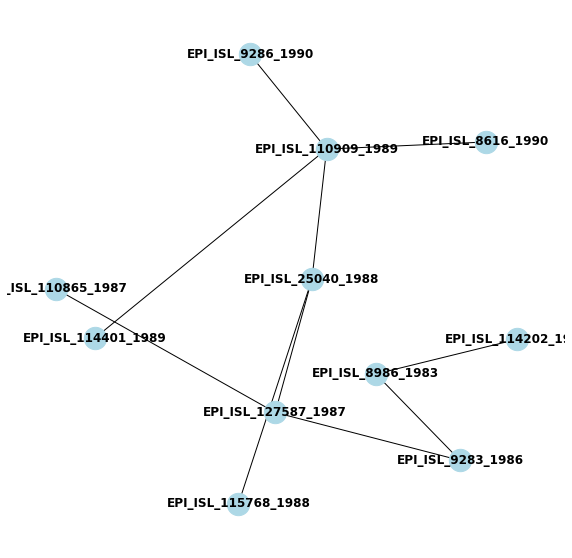

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
H = nx.subgraph(MST, [v.name for v in Vs])
nx.draw(H, with_labels=True, font_weight='bold', node_color='lightblue', node_size=500)

In [ ]:
[i.name for i in Vs]

['EPI_ISL_25040_1988',
 'EPI_ISL_127587_1987',
 'EPI_ISL_110909_1989',
 'EPI_ISL_114401_1989',
 'EPI_ISL_25040_1988',
 'EPI_ISL_110865_1987',
 'EPI_ISL_9283_1986',
 'EPI_ISL_8986_1983',
 'EPI_ISL_114202_1982',
 'EPI_ISL_9286_1990',
 'EPI_ISL_8616_1990',
 'EPI_ISL_115768_1988']

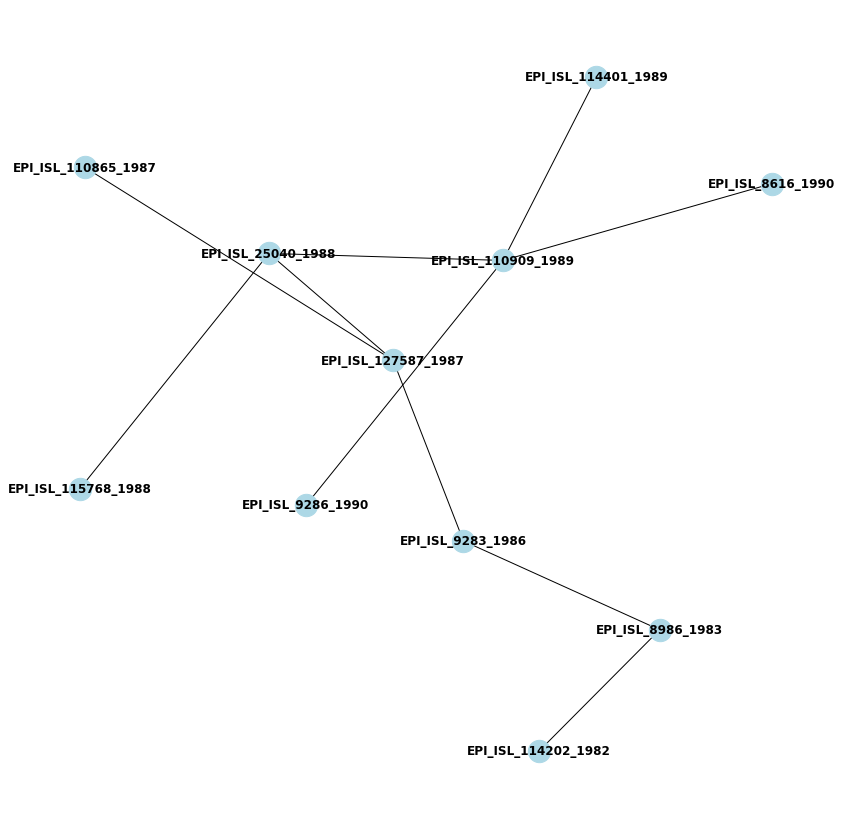

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
H = nx.subgraph(MST, [v.name for v in Vs])
nx.draw(H, with_labels=True, font_weight='bold', node_color='lightblue', node_size=500)

In [ ]:
Ve = extra_vertices_with_bfs(M, Vs, 10)
print([i.name for i in Ve])


['EPI_ISL_14692_1986', 'EPI_ISL_111022_1992', 'EPI_ISL_25044_1991', 'EPI_ISL_8670_1985', 'EPI_ISL_9277_1985', 'EPI_ISL_110956_1992', 'EPI_ISL_114607_1991', 'EPI_ISL_115698_1979', 'EPI_ISL_8700_1984', 'EPI_ISL_8987_1984']


In [ ]:
V = Vs + Ve
newick_str = newick_for_initial_tree(V)
newick_str

'(EPI_ISL_25040_1988,(EPI_ISL_127587_1987,(EPI_ISL_110909_1989,(EPI_ISL_114401_1989,(EPI_ISL_25040_1988,(EPI_ISL_110865_1987,(EPI_ISL_9283_1986,(EPI_ISL_8986_1983,(EPI_ISL_114202_1982,(EPI_ISL_9286_1990,(EPI_ISL_8616_1990,(EPI_ISL_115768_1988,(EPI_ISL_14692_1986,(EPI_ISL_111022_1992,(EPI_ISL_25044_1991,(EPI_ISL_8670_1985,(EPI_ISL_9277_1985,(EPI_ISL_110956_1992,(EPI_ISL_114607_1991,(EPI_ISL_115698_1979,(EPI_ISL_8700_1984,EPI_ISL_8987_1984)))))))))))))))))))));'

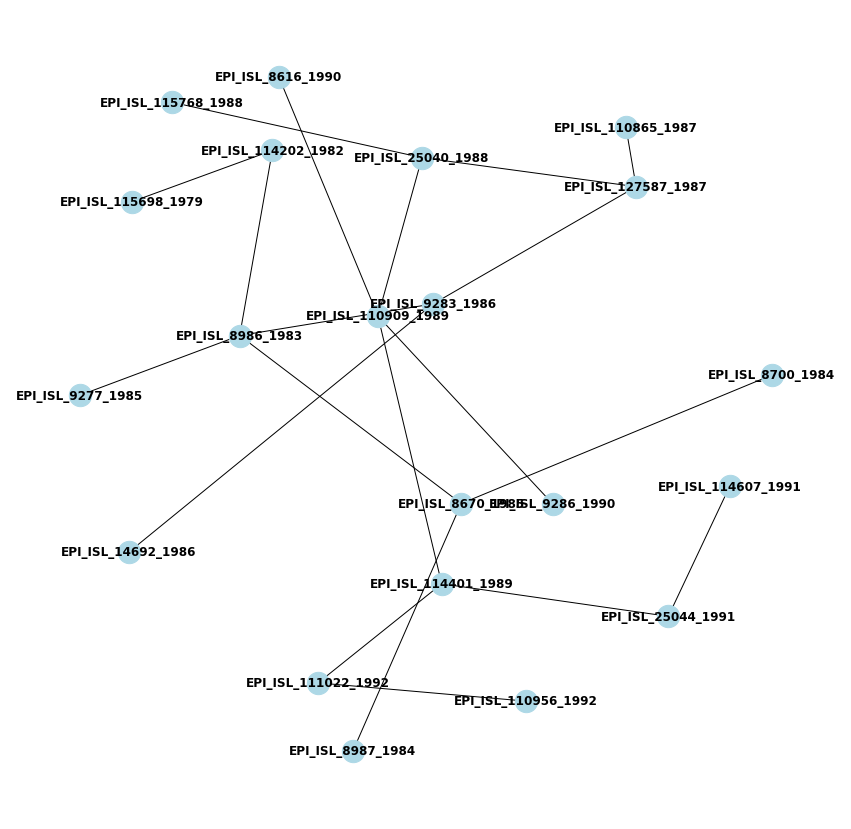

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
H = nx.subgraph(MST, [v.name for v in V])
nx.draw(H, with_labels=True, font_weight='bold', node_color='lightblue', node_size=500)

In [ ]:
[i.name for i in M.Get_vertex('EPI_ISL_9016_1998').subtree]

['EPI_ISL_9016_1998',
 'EPI_ISL_115563_1996',
 'EPI_ISL_8638_2000',
 'EPI_ISL_14240_2000']

## Merge subtree into global MST

In [ ]:
# takes networkx trees as parameters
def merge_trees(old_subtree, updated_subtree, global_tree):
  new_vertices = [v for v in list(updated_subtree.nodes) if v not in list(old_subtree.nodes)]
  vertices_to_remove = [v for v in list(old_subtree.nodes) if v not in list(updated_subtree.nodes)]

  for v in vertices_to_remove:
    global_tree.remove_node(v)
  
  edges_to_add = []
  for v in new_vertices:
    new_edges = list(updated_subtree.edges(v))
    for e in new_edges:
      if e not in edges_to_add:
        edges_to_add.append(e)
  
  for e in edges_to_add:
    global_tree.add_edge(e)
  
  return global_tree

In [ ]:
def find_simple_subtree(T, threshold):
  vertices_to_visit = [T.leaves[0]]
  subtree = []

  while len(subtree) < threshold:
    current_v = vertices_to_visit.pop()
    print(f'current_v: {current_v}')
    if current_v not in subtree:
      subtree.append(current_v)
    # subtree.append(current_v.neighbors)
    for n in current_v.neighbors:
      if n not in vertices_to_visit:
        vertices_to_visit.append(n)
    print(f'subtree: {len(subtree)}')
  
  return subtree

In [ ]:
for vertex_name in M.vertex_map.keys():
  M.Get_vertex(vertex_name).subtree = []
# Vs = find_subtree(M, 10)
simple_Vs = find_simple_subtree(M, 7)

Streaming output truncated to the last 5000 lines.
current_v: <__main__.Vertex object at 0x7f34356209d0>
subtree: 3
current_v: <__main__.Vertex object at 0x7f3435620520>
subtree: 3
current_v: <__main__.Vertex object at 0x7f34356209d0>
subtree: 3
current_v: <__main__.Vertex object at 0x7f3435620520>
subtree: 3
current_v: <__main__.Vertex object at 0x7f34356209d0>
subtree: 3
current_v: <__main__.Vertex object at 0x7f3435620520>
subtree: 3
current_v: <__main__.Vertex object at 0x7f34356209d0>
subtree: 3
current_v: <__main__.Vertex object at 0x7f3435620520>
subtree: 3
current_v: <__main__.Vertex object at 0x7f34356209d0>
subtree: 3
current_v: <__main__.Vertex object at 0x7f3435620520>
subtree: 3
current_v: <__main__.Vertex object at 0x7f34356209d0>
subtree: 3
current_v: <__main__.Vertex object at 0x7f3435620520>
subtree: 3
current_v: <__main__.Vertex object at 0x7f34356209d0>
subtree: 3
current_v: <__main__.Vertex object at 0x7f3435620520>
subtree: 3
current_v: <__main__.Vertex object at 0

KeyboardInterrupt: ignored

In [ ]:
for subtree_vertex in simple_Vs:
  print(subtree_vertex.name)

In [ ]:
# seq_id = list(sequences.keys())
# G = nx.Graph()
# G.add_nodes_from(seq_id)
# for i in range(len(seq_id)):
#   for j in range(i+1, len(seq_id)):
#     G.add_edge(seq_id[i], seq_id[j], weight = dist_mat[i][j])